### **2. 앱 온라인몰(이용정보) Data Analysis**

--- 
#### 2.1. **구매행동 분석**

- 2.1.1 구매빈도 및 금액 분석 : 나이, 성별, 가구 유형별 구매 빈도와 구매 금액 차이 분석 
> 시각화 및 Group 별 통계 검정 진행

- 2.1.2 재구매 행동 분석 : 특정 제품의 재구매율 및 패턴분석 
> 코호트 분석

#### 2.2. **특정 키워드 회원 및 소비성향 파악**

- 2.2.1 특정상품 구매 회원 분석 : 나이, 성별, 가구 유형, 소득, 회원타입에 따른 특정 상품 구매 회원 세분화
> '유기농', '파이토케미컬', '미네랄', '항암' 등 

- 2.2.2 장바구니 분석 : 같이 구매한 상품 분석 
> 특정 상품 구매 Network 분석

#### 2.3. **마케팅 효과 분석 (10월 25일 이후)**

- 2.3.1 외부 마케팅 효과 분석: 마케팅 동의 여부에 따른 구매 패턴 비교
> 주 단위 시계열 분석

- 2.3.2 앱 오픈 전후 효과 분석 : 이벤트 전 (1,2,3월), 이벤트 후 (4,5,6월), 전환율 측정 기간 (7,8,9월)
> 그룹별 시각화

- 2.3.3 마케팅 수신여부 분석 : 마케팅 수신에 따른 구매 패턴 비교
> 그룹별 시각화

-'유기농', '파이토케미컬', '미네랄', '항암' 등 (같이 구매한 내역)

--- 

#### **앱 온라인몰 Table List**

주신 내용을 테이블명과 테이블 설명으로 정리해 드리겠습니다:

| 테이블명                    | 테이블 설명                                     |
|-----------------------------|------------------------------------------------|
| **purchase_frequency**          | (2.1.1) 구매 빈도 및 금액 분석                 |
| **repurchase_behavior_cohort_base**         | (2.1.2) 재구매 행동 분석                       |

<br>

| 테이블명                    | 테이블 설명                                     |
|-----------------------------|------------------------------------------------|
| **keyword_purchase_frequency**          | (2.2.1) 특정상품 구매회원 분석                   |
| **keyword_purchase_nework**        | (2.2.2) 장바구니 분석            |

<br>

| 테이블명                    | 테이블 설명                                     |
|-----------------------------|------------------------------------------------|
| **marketing_effect** | (2.3.1) 일단위 마케팅 효과 분석 |
| **marketing_app_effect**            | (2.3.2) 앱 오픈 전후 효과 분석                       |
| **marketing_purchase_beahvior**            | (2.3.3) 마케팅 수신여부 분석                      |

--- 

#### **Library and Setting**

In [63]:
# system setting 
import os 
import sys 
import importlib
import datetime
from tqdm import tqdm 
import warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import decimal


# Clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from pycaret.classification import *
#from pycaret.regression import *

# SHAP 
import shap

# visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import squarify


# Statistical Test
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

# Sys PATH
sys.path.append(os.path.dirname(os.getcwd()))


In [3]:
# UDF 

from src.module.root.postgre import PostgreSQL
from src.module.root.datacontainer import DirectoryHandler

In [4]:
plt.rcParams['font.family'] = 'NanumGothic'  # 한글 폰트를 NanumGothic으로 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [5]:
# Setting 
pd.set_option('display.max_columns', None)
%matplotlib inline


work_dir = DirectoryHandler.find_directory(
    start_path=os.getcwd(),
    target_directory_name='online_mall'
)
config_path = f'{work_dir}/private_configs.yaml'


--- 
#### 2.1. **구매행동 분석**

- 2.1.1 구매빈도 및 금액 분석 : 나이, 성별, 가구 유형별 구매 빈도와 구매 금액 차이 분석 (gender 추가)
> 시각화 및 Group 별 통계 검정 진행


| 테이블명               | 컬럼명                | 컬럼한글명      |
|------------------------|-----------------------|-----------------|
| purchase_frequency | member_code           | 조합원코드      |
| purchase_frequency | age             | 연령        |
| purchase_frequency | age_group             | 연령그룹        |
| purchase_frequency | gender           | 성별        |
| purchase_frequency | state                 | 주소지(시도)    |
| purchase_frequency | city                  | 주소지(시군구)  |
| purchase_frequency | household_size        | 가구인원수      |
| purchase_frequency | household_type        | 가구유형        |
| purchase_frequency | member_type           | 회원유형        |
| purchase_frequency | purchase_count        | 구매빈도        |
| purchase_frequency | purchase_amount       | 구매금액        |
| purchase_frequency | avg_purchase_day_diff | 평균 구매기간      |


In [132]:
# PostgreSQL 연결
postgre = PostgreSQL(config_file_path=config_path, request_url='local_postgre')
postgre.connect()

# 스키마 'online_mall'에서 테이블 목록 가져오는 쿼리
query = """
    (select * from app_online_mall.purchase_frequency where member_type in ('실버'))

    union all 

    (select * from app_online_mall.purchase_frequency where member_type in ('골드') limit 1000)

    union all 

    (select * from app_online_mall.purchase_frequency where member_type in ('프리미엄'))
"""

purchase_frequency = postgre.read_data(query)
postgre.close() 

Initialize Class
Connected to PostgreSQL
PostgreSQL connection is closed


In [138]:
purchase_frequency.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2911 entries, 0 to 2910
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   member_code              2911 non-null   object 
 1   age                      2911 non-null   float64
 2   age_group                2911 non-null   object 
 3   gender                   2911 non-null   object 
 4   state                    2911 non-null   object 
 5   city                     2911 non-null   object 
 6   household_size           2911 non-null   int64  
 7   household_type           2911 non-null   object 
 8   member_type              2911 non-null   object 
 9   purchase_count           2911 non-null   int64  
 10  purchase_amount          2911 non-null   float64
 11  avg_purchase_day_differ  2054 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 273.0+ KB


In [139]:
purchase_frequency.head()

,member_code,age,age_group,gender,state,city,household_size,household_type,member_type,purchase_count,purchase_amount,avg_purchase_day_differ
0,HB2400061,38.0,40대,여,전북특별자치도,전주시,4,부모+자녀,실버,1,32280.0,NaN
1,HB2400072,49.0,50대,여,서울특별시,양천구,4,부모+자녀,실버,2,116870.0,9.0
2,HB2400082,43.0,40대,여,경기도,김포시,2,부부,실버,1,47630.0,NaN
3,HB2400094,50.0,50대,여,광주광역시,광산구,3,부부,실버,1,65040.0,NaN
4,HB2400204,44.0,40대,여,경상남도,창원시,4,부모+자녀,실버,1,133460.0,NaN


In [140]:
# Data type Convert 

purchase_frequency = purchase_frequency.applymap(lambda x: float(x) if isinstance(x, decimal.Decimal) else x)
purchase_frequency['household_size'] = purchase_frequency['household_size'].astype('int')


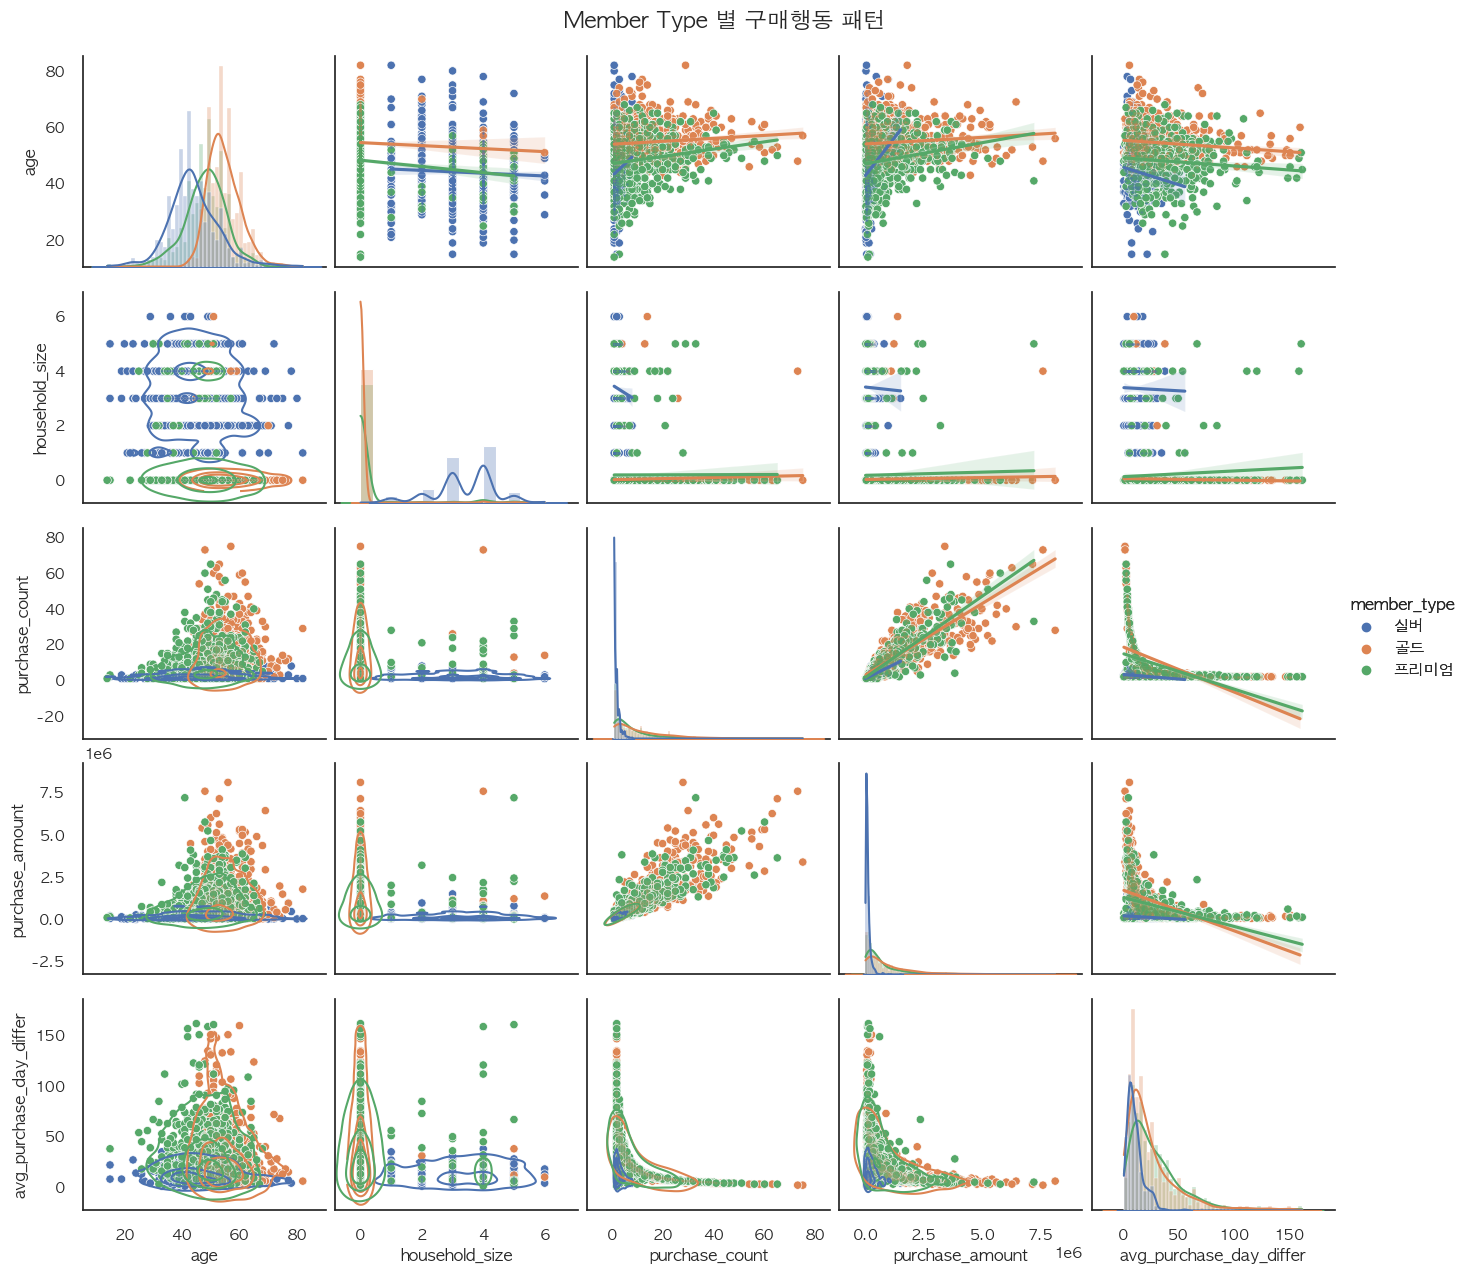

In [137]:
sns.set(
    font_scale=1, 
    style='white', 
    font="AppleGothic", 
    rc={"axes.unicode_minus": False}

)

# PairGrid 생성, 색상 팔레트 지정
g = sns.pairplot(
    purchase_frequency[
        [ 
            'age',
            'household_size',
            'purchase_count',
            'purchase_amount',
            'avg_purchase_day_differ',
            'member_type',
        ]
    ], 
    hue="member_type",
    height=2.5  
)
    
g.map_diag(sns.histplot, kde=True, alpha=0.3)

g.map_lower(sns.scatterplot, alpha=0.1, s=3)  # s는 마커 크기
g.map_lower(sns.kdeplot, color="w", levels=4, alpha=1)
g.map_upper(sns.regplot, scatter_kws={'s': 3, 'alpha': 0.3})

g.add_legend()

g.fig.suptitle("Member Type 별 구매행동 패턴", y=1.02, fontsize=16)  # y로 제목 위치 조정

# 플롯 보여주기
plt.show()

- 구매 주기(Target)에 대한 Regression

In [64]:
purchase_frequency.head()

,member_code,age,age_group,state,city,household_size,household_type,member_type,purchase_count,purchase_amount,avg_purchase_day_differ
0,HB2400004,23.0,20대,서울특별시,금천구,1,부모+자녀,실버,1,100900.0,NaN
1,HB2400043,33.0,30대,서울특별시,영등포구,1,본인(1인가구),실버,2,59360.0,35.0
2,HB2400061,38.0,40대,전북특별자치도,전주시,4,부모+자녀,실버,1,32280.0,NaN
3,HB2400072,49.0,50대,서울특별시,양천구,4,부모+자녀,실버,2,116870.0,9.0
4,HB2400082,43.0,40대,경기도,김포시,2,부부,실버,1,47630.0,NaN


In [135]:

formula = 'avg_purchase_day_differ ~ age + gender + state + household_size + member_type + purchase_count + purchase_amount'
glm_gaussian = smf.glm(formula=formula, data=purchase_frequency, family=sm.families.Gaussian()).fit()
print(glm_gaussian.summary())


                    Generalized Linear Model Regression Results                    
Dep. Variable:     avg_purchase_day_differ   No. Observations:                 2054
Model:                                 GLM   Df Residuals:                     2029
Model Family:                     Gaussian   Df Model:                           24
Link Function:                    Identity   Scale:                          350.62
Method:                               IRLS   Log-Likelihood:                -8919.8
Date:                     Wed, 16 Oct 2024   Deviance:                   7.1140e+05
Time:                             19:48:17   Pearson chi2:                 7.11e+05
No. Iterations:                          3   Pseudo R-squ. (CS):             0.4282
Covariance Type:                 nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

- 해석 :  
coef는 선형회귀 모형의 계수(기울기)로  위 결과를 예를 들어 설명한다면 **gender[T.여]** 일경우 남성대비 평균 구매 -3.0515일이 줄어드는 것으로 해석 
단,  P>|z| (P value)가 0.05 보다 클경우 해당 계수가 유의하지 않기에 해석에 주의 할 것


- 구매 총액에 대한 Regression

In [136]:
formula = 'purchase_amount ~ age + gender + state + household_size + member_type + purchase_count + avg_purchase_day_differ'
glm_gaussian = smf.glm(formula=formula, data=purchase_frequency, family=sm.families.Gaussian()).fit()
print(glm_gaussian.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:        purchase_amount   No. Observations:                 2054
Model:                            GLM   Df Residuals:                     2029
Model Family:                Gaussian   Df Model:                           24
Link Function:               Identity   Scale:                      2.6443e+11
Method:                          IRLS   Log-Likelihood:                -29913.
Date:                Wed, 16 Oct 2024   Deviance:                   5.3653e+14
Time:                        19:50:18   Pearson chi2:                 5.37e+14
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9454
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1

- 해석


--- 
- 2.1.2 재구매 행동 분석 : 특정 제품의 재구매율 및 패턴분석 
> 코호트 분석


| 테이블명                           | 컬럼명            | 컬럼한글명          |
|------------------------------------|-------------------|---------------------|
| repurchase_behavior_cohort_base | product_code      | 상품코드            |
| repurchase_behavior_cohort_base | repurchase_group  | 재구매횟수그룹      |
| repurchase_behavior_cohort_base | member_count      | 재구매그룹별멤버수  |
| repurchase_behavior_cohort_base | repurchase_rate   | 재구매율            |
| repurchase_behavior_cohort_base | avg_unit_price    | 평균가격            |

In [77]:
# PostgreSQL 연결
postgre = PostgreSQL(config_file_path=config_path, request_url='local_postgre')
postgre.connect()

# 스키마 'online_mall'에서 테이블 목록 가져오는 쿼리
query = """
    select * 
    from app_online_mall.repurchase_behavior_cohort_base
"""

repurchase_behavior_cohort_base = postgre.read_data(query)
postgre.close() 

Initialize Class
Connected to PostgreSQL
PostgreSQL connection is closed


In [78]:
repurchase_behavior_cohort_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34953 entries, 0 to 34952
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_code      34953 non-null  object
 1   product_name      34953 non-null  object
 2   repurchase_group  34953 non-null  int64 
 3   member_count      34953 non-null  int64 
 4   repurchase_rate   34953 non-null  object
 5   avg_unit_price    34953 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.6+ MB


In [79]:
repurchase_behavior_cohort_base.head()

,product_code,product_name,repurchase_group,member_count,repurchase_rate,avg_unit_price
0,00000ROM00,유기농화이트와인식초(쿱이탈리아)*500ml*로마유통,1,590,1.00000000000000000000,9333
1,00000ROM00,유기농화이트와인식초(쿱이탈리아)*500ml*로마유통,2,31,0.05254237288135593220,9333
2,00000ROM00,유기농화이트와인식초(쿱이탈리아)*500ml*로마유통,3,5,0.00847457627118644068,9333
3,00000SCD00,라이스페이퍼*300g*에스씨디,1,1113,1.00000000000000000000,2769
4,00000SCD00,라이스페이퍼*300g*에스씨디,2,40,0.03593890386343216532,2769


- 평균 가격과 재구매율 관의 상관관계 

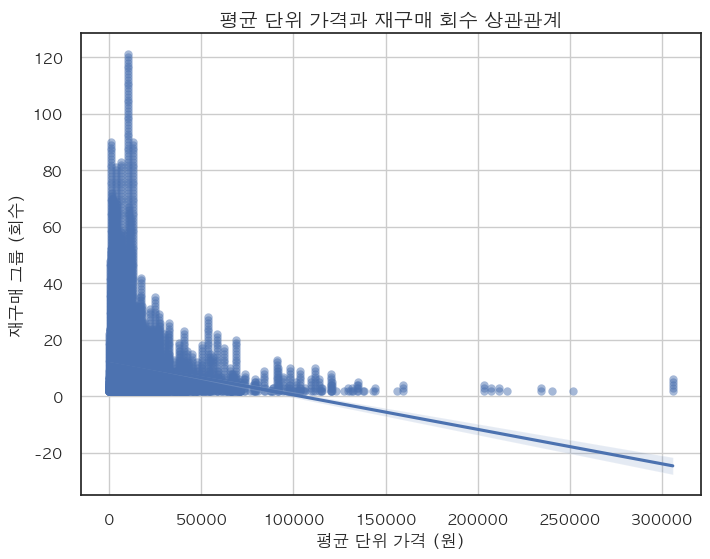

In [130]:

# Scatterplot을 사용하여 상관관계 시각화

filtered_df = repurchase_behavior_cohort_base[repurchase_behavior_cohort_base['repurchase_group'] >= 2]
plt.figure(figsize=(8, 6))
sns.regplot(x='avg_unit_price', y='repurchase_group', data=filtered_df, scatter_kws={'alpha':0.5})

# 그래프 타이틀과 축 레이블 설정
plt.title("평균 단위 가격과 재구매 회수 상관관계", fontsize=14)
plt.xlabel("평균 단위 가격 (원)")
plt.ylabel("재구매 그룹 (회수)")

# 그래프 출력
plt.grid(True)
plt.show()

- 재구매율 Top 10

In [122]:
repurchase_top10 = repurchase_behavior_cohort_base[repurchase_behavior_cohort_base['repurchase_group'] == 2].sort_values(by='repurchase_rate', ascending=False).head(10)

repurchase_top10

,product_code,product_name,repurchase_group,member_count,repurchase_rate,avg_unit_price
16850,35800GO100,자연드림집밥(반찬),2,94,0.97916666666666666667,10006
19634,48000IS500,제철채소과일꾸러미*쿱농산APC,2,32,0.82051282051282051282,20000
19663,48100IS500,암을예방할수있는항암채소과일꾸러미*쿱농산APC,2,25,0.80645161290322580645,20000
19116,4560800000,통밀가득모닝빵(5개)*매장,2,4,0.80000000000000000000,2550
18238,4200800000,두부면샐러드*스토어즉석,2,3,0.75000000000000000000,7000
9676,20000DHG00,유정란ND*10구*도희네유정란구례,2,30578,0.61662868781382967997,4493
11506,21001PB300,유정란ND*10구*제주웰빙,2,328,0.59963436928702010969,4492
20224,50013DF800,JUST기픈물*1000mL(12개입)*솔트로드고성,2,10229,0.59391511351100272891,7250
30948,80019B5000,멍멍라이트*1.2kg(300g*4개)*우리와,2,265,0.56623931623931623932,14532
30995,80024B5000,야미라이트*1.2kg(300g*4개)*우리와,2,138,0.56557377049180327869,15164


- 재구매율 상위 Top10의 Cohort

In [114]:
top10_product_list = repurchase_top10['product_name'].unique()

In [115]:
filtered_df = repurchase_behavior_cohort_base[repurchase_behavior_cohort_base['product_name'].isin(top10_product_list)]

In [116]:
cohort_data = filtered_df.pivot_table(
    index='product_name', 
    columns='repurchase_group', 
    values='repurchase_rate'
)

cohort_data

repurchase_group,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
product_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JUST기픈물*1000mL(12개입)*솔트로드고성,1.0,0.593915,0.395401,0.264646,0.179295,0.121988,0.085467,0.059107,0.042153,0.030541,0.023399,0.016838,0.012483,0.009871,0.007316,0.005458,0.004064,0.003542,0.002729,0.002090,0.001742,0.001335,0.001103,0.000987,0.000755,0.000523,0.000290,0.000232,0.000174,0.000116,0.000116,0.000116,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
두부면샐러드*스토어즉석,1.0,0.750000,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
멍멍라이트*1.2kg(300g*4개)*우리와,1.0,0.566239,0.373932,0.264957,0.177350,0.121795,0.083333,0.049145,0.034188,0.012821,0.004274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
암을예방할수있는항암채소과일꾸러미*쿱농산APC,1.0,0.806452,0.677419,0.354839,0.290323,0.225806,0.161290,0.032258,0.032258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
야미라이트*1.2kg(300g*4개)*우리와,1.0,0.565574,0.340164,0.204918,0.139344,0.114754,0.073770,0.036885,0.024590,0.020492,0.012295,0.012295,0.008197,0.008197,0.008197,0.004098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
유정란ND*10구*도희네유정란구례,1.0,0.616629,0.454516,0.354776,0.289278,0.241001,0.202868,0.171510,0.146161,0.126177,0.108653,0.093347,0.079231,0.067676,0.057856,0.049265,0.042832,0.035915,0.030450,0.026215,0.022142,0.018694,0.015467,0.012563,0.010063,0.008308,0.006574,0.005606,0.004598,0.004053,0.003489,0.003065,0.002601,0.002259,0.001896,0.001714,0.001512,0.001391,0.001129,0.000907,0.000827,0.000706,0.000605,0.000524,0.000444,0.000383,0.000323,0.000282,0.000202,0.000141,0.00004,0.00004,0.00004,0.00004,0.00004,0.000040,0.000040,0.000040,0

- member type 별 재구매 Top10

--- 
#### 2.2. **특정 키워드 회원 및 소비성향 파악**

- 2.2.1 특정상품 구매 회원 분석 : 나이, 성별, 가구 유형, 소득, 회원타입에 따른 특정 상품 구매 회원 세분화
> '유기농', '파이토케미컬', '미네랄', '항암' 등 

| 테이블명               | 컬럼명                | 컬럼한글명      |
|------------------------|-----------------------|-----------------|
| keyword_purchase_frequency | member_code           | 조합원코드      |
| keyword_purchase_frequency | age             | 연령        |
| keyword_purchase_frequency | age_group             | 연령그룹        |
| keyword_purchase_frequency | gender           | 성별        |
| keyword_purchase_frequency | state                 | 주소지(시도)    |
| keyword_purchase_frequency | city                  | 주소지(시군구)  |
| keyword_purchase_frequency | household_size        | 가구인원수      |
| keyword_purchase_frequency | household_type        | 가구유형        |
| keyword_purchase_frequency | member_type           | 회원유형        |
| keyword_purchase_frequency | product_code       | 구매코드        |
| keyword_purchase_frequency | product_name       | 구매상품명        |
| keyword_purchase_frequency | category_large       | 대분류        |
| keyword_purchase_frequency | category_medium       | 중분류        |
| keyword_purchase_frequency | keyword_group      | 키워드 그룹       |
| keyword_purchase_frequency | purchase_count        | 구매빈도        |
| keyword_purchase_frequency | purchase_amount       | 구매금액        |


In [145]:
# PostgreSQL 연결
postgre = PostgreSQL(config_file_path=config_path, request_url='local_postgre')
postgre.connect()

# 스키마 'online_mall'에서 테이블 목록 가져오는 쿼리
query = """
    select * 
    from app_online_mall.keyword_purchase_frequency
"""

keyword_purchase_frequency = postgre.read_data(query)
postgre.close() 

Initialize Class
Connected to PostgreSQL
PostgreSQL connection is closed


In [144]:
keyword_purchase_frequency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742288 entries, 0 to 742287
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   member_code      742288 non-null  object
 1   age              742288 non-null  object
 2   age_group        742288 non-null  object
 3   gender           742288 non-null  object
 4   state            742288 non-null  object
 5   city             742288 non-null  object
 6   household_size   742288 non-null  object
 7   household_type   742288 non-null  object
 8   member_type      742288 non-null  object
 9   product_code     742288 non-null  object
 10  product_name     742288 non-null  object
 11  category_large   742288 non-null  object
 12  category_medium  742288 non-null  object
 13  keyword_group    742288 non-null  object
 14  purchase_count   742288 non-null  object
 15  purchase_amount  742288 non-null  object
dtypes: object(16)
memory usage: 90.6+ MB


In [146]:
keyword_purchase_frequency.head()

,member_code,age,age_group,gender,state,city,household_size,household_type,member_type,product_code,product_name,category_large,category_medium,keyword_group,purchase_count,purchase_amount
0,317352014,53,50대,미확인,제주특별자치도,제주시,0,미확인,골드,64300KS500,항암참외(진차메)*1.5kg*유,과일/과채,토마토/참외/수박/메론,항암,2,23800
1,317352014,53,50대,미확인,제주특별자치도,제주시,0,미확인,골드,77111KIC00,큰토마토(김문중)*항암*1kg*무이상,과일/과채,토마토/참외/수박/메론,항암,1,10200
2,317352014,53,50대,미확인,제주특별자치도,제주시,0,미확인,골드,77111MOU00,큰토마토(수페리)*항암*1kg*무이상,과일/과채,토마토/참외/수박/메론,항암,1,6880
3,317352014,53,50대,미확인,제주특별자치도,제주시,0,미확인,골드,99544II200,찰밤고구마(해야)*항암*1.5kg*유,채소,고구마/감자,항암,1,10500
4,317453788,61,60대,미확인,경상북도,포항시,0,미확인,골드,33666ED600,생표고(보령)*항암*200g*무이상,채소,버섯,항암,2,8700


In [152]:
grouped = keyword_purchase_frequency.groupby(['member_type', 'keyword_group'])['purchase_count'].sum().reset_index()
grouped

,member_type,keyword_group,purchase_count
0,골드,미네랄,30170
1,골드,유기농,443269
2,골드,파이토,1506
3,골드,항암,976075
4,실버,미네랄,104
5,실버,유기농,767
6,실버,항암,848
7,프리미엄,미네랄,421
8,프리미엄,유기농,3696
9,프리미엄,파이토,21


- 회원 타입별 구매 비율

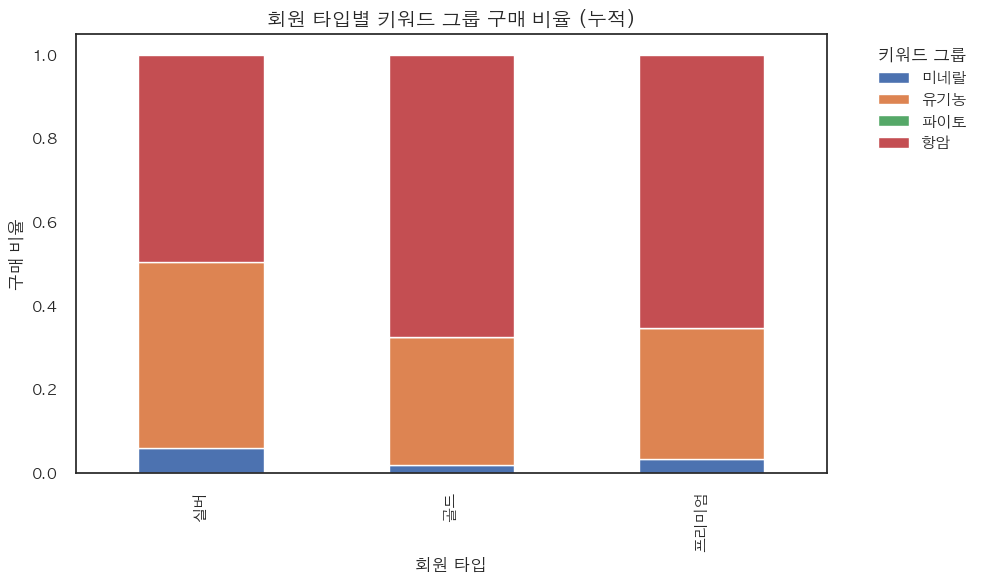

In [161]:

# 전체 회원 타입과 키워드 그룹별 구매 횟수 합계로 피벗 테이블 생성

grouped = keyword_purchase_frequency.groupby(['member_type', 'keyword_group'])['purchase_count'].sum().reset_index()

# 전체 회원 타입별 총 구매 횟수 계산
total_purchases = grouped.groupby('member_type')['purchase_count'].sum().reset_index()
total_purchases.columns = ['member_type', 'total_purchase_count']

# 비율 계산: 각 키워드 그룹의 구매 횟수를 전체 구매 횟수로 나눠서 비율 생성
grouped = pd.merge(grouped, total_purchases, on='member_type')
grouped['purchase_ratio'] = grouped['purchase_count'] / grouped['total_purchase_count']
grouped['member_type'] = pd.Categorical(grouped['member_type'], categories=['실버', '골드', '프리미엄'], ordered=True)

# 데이터 피벗: 누적 Bar Chart를 위한 데이터 형태로 변환
pivot_table = grouped.pivot(index='member_type', columns='keyword_group', values='purchase_ratio').fillna(0)

# 숫자형 데이터로 변환 (혹시 모를 데이터 타입 문제 해결)
pivot_table = pivot_table.apply(pd.to_numeric)

# 누적된 Bar Chart 생성
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca())

# 그래프 제목과 축 레이블 설정
plt.title("회원 타입별 키워드 그룹 구매 비율 (누적)", fontsize=14)
plt.xlabel("회원 타입")
plt.ylabel("구매 비율")

# 범례 추가
plt.legend(title='키워드 그룹', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 출력
plt.tight_layout()
plt.show()

In [160]:
pivot_table


keyword_group,미네랄,유기농,파이토,항암
member_type,,,,
골드,0.020792,0.305488,0.001038,0.672682
실버,0.060500,0.446190,0.000000,0.493310
프리미엄,0.035462,0.311321,0.001769,0.651449


- 연령대별 구매 비율

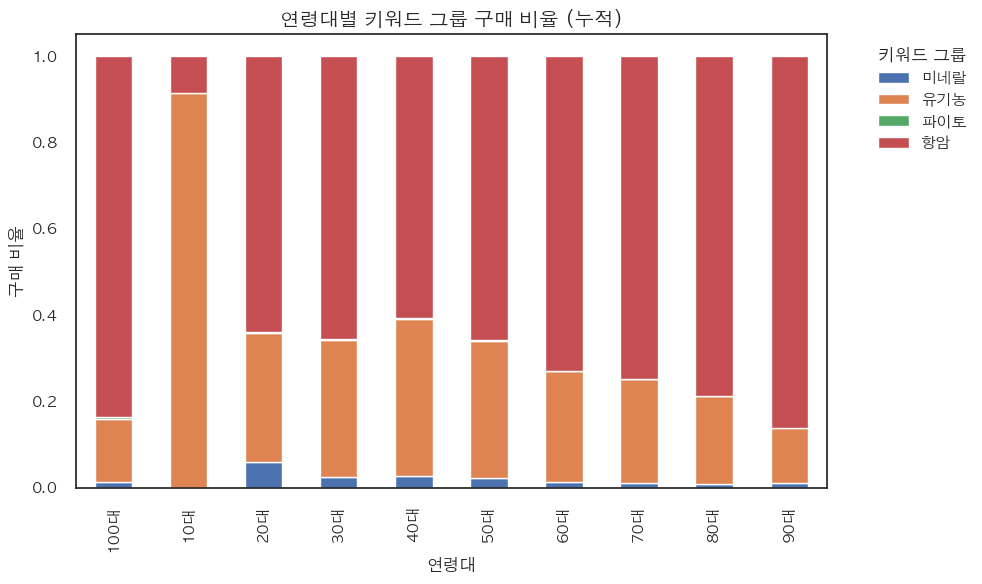

In [169]:

# 전체 회원 타입과 키워드 그룹별 구매 횟수 합계로 피벗 테이블 생성
grouped = keyword_purchase_frequency.groupby(['age_group', 'keyword_group'])['purchase_count'].sum().reset_index()

# 전체 회원 타입별 총 구매 횟수 계산
total_purchases = grouped.groupby('age_group')['purchase_count'].sum().reset_index()
total_purchases.columns = ['age_group', 'total_purchase_count']

# 비율 계산: 각 키워드 그룹의 구매 횟수를 전체 구매 횟수로 나눠서 비율 생성
grouped = pd.merge(grouped, total_purchases, on='age_group')
grouped['purchase_ratio'] = grouped['purchase_count'] / grouped['total_purchase_count']

# 데이터 피벗: 누적 Bar Chart를 위한 데이터 형태로 변환
pivot_table = grouped.pivot_table(index='age_group', columns='keyword_group', values='purchase_ratio', aggfunc='sum').fillna(0)

# 숫자형 데이터로 변환 (혹시 모를 데이터 타입 문제 해결)
pivot_table = pivot_table.apply(pd.to_numeric)

# 누적된 Bar Chart 생성
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca())

# 그래프 제목과 축 레이블 설정
plt.title("연령대별 키워드 그룹 구매 비율 (누적)", fontsize=14)
plt.xlabel("연령대")
plt.ylabel("구매 비율")

# 범례 추가
plt.legend(title='키워드 그룹', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 출력
plt.tight_layout()
plt.show()

In [170]:
pivot_table

keyword_group,미네랄,유기농,파이토,항암
age_group,,,,
100대,0.014599,0.145985,0.003650,0.835766
10대,0.000000,0.914286,0.000000,0.085714
20대,0.060255,0.298957,0.001159,0.639629
30대,0.025563,0.317850,0.000672,0.655914
40대,0.027943,0.363820,0.001419,0.606818
50대,0.023221,0.317979,0.001116,0.657684
60대,0.013773,0.255798,0.000780,0.729649
70대,0.010643,0.240940,0.000559,0.747858
80대,0.008399,0.204925,0.000573,0.786103


- 해석 : 10대 사용자 자체가 적어 수치에 Bias 생기므로 주의

--- 
- 2.2.2 장바구니 분석 : 같이 구매한 상품 분석 
> 특정 상품 구매 Network 분석


| 테이블명               | 컬럼명                | 컬럼한글명      |
|------------------------|-----------------------|-----------------|
| keyword_purchase_network | keyword_rnk           | 그룹Top100구분      |
| keyword_purchase_network | product_name             | 제품명        |
| keyword_purchase_network | purchase_amount             | 제품구매 총액        |
| keyword_purchase_network | rnk           | 구매액 순위        |



In [191]:
# PostgreSQL 연결
postgre = PostgreSQL(config_file_path=config_path, request_url='local_postgre')
postgre.connect()

# 스키마 'online_mall'에서 테이블 목록 가져오는 쿼리
query = """
    select 
        keyword_rnk,  
        product_name,
        sum(purchase_amount) as purchase_amount,
        row_number() over (partition by keyword_rnk order by sum(purchase_amount) desc) as rnk 
        
    from app_online_mall.keyword_purchase_network
    group by 
        keyword_rnk, 
        product_name
    
"""

keyword_purchase_network = postgre.read_data(query)
postgre.close() 

Initialize Class
Connected to PostgreSQL
PostgreSQL connection is closed


In [192]:
keyword_purchase_network.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8233 entries, 0 to 8232
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   keyword_rnk      8233 non-null   object
 1   product_name     8233 non-null   object
 2   purchase_amount  8233 non-null   object
 3   rnk              8233 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 257.4+ KB


In [195]:
keyword_purchase_network = keyword_purchase_network.applymap(lambda x: float(x) if isinstance(x, decimal.Decimal) else x)

In [196]:
keyword_purchase_network.head()

,keyword_rnk,product_name,purchase_amount,rnk
0,미네랄top100,(진공)NonGMO돈육항정살*300g*돈구라,5261300.0,1
1,미네랄top100,유정란ND*10구*도희네유정란구례,4931030.0,2
2,미네랄top100,초임계식물성알티지오메가3*30g*알피바이오,3252390.0,3
3,미네랄top100,칼슘마그네슘디*60g*(주)브이벤처스,3216790.0,4
4,미네랄top100,NonGMO한우불고기*200g*건강한한우,1824220.0,5


- 항암 제품 구매 Top100명의 주 구매 카테고리

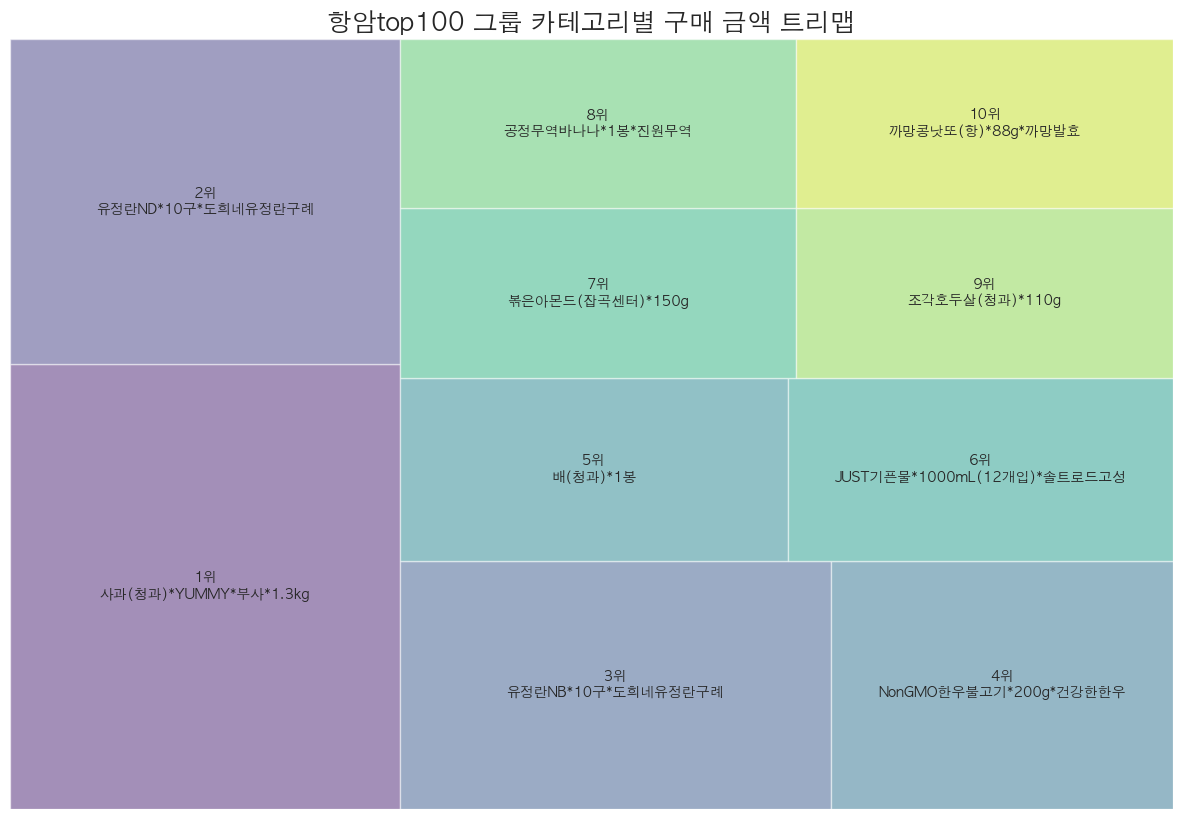

In [201]:
# 특정 keyword_rnk ('항암top100')에 대한 트리맵 그리기 예시
keyword = '항암top100'
filter_condition = (keyword_purchase_network['keyword_rnk'] == keyword) & (keyword_purchase_network['rnk'] <= 10)
filtered_df = keyword_purchase_network[filter_condition]

# 등수와 상품명을 함께 라벨로 표시
filtered_df['label'] = filtered_df.apply(lambda x: f"{x['rnk']}위\n{x['product_name']}", axis=1)

# 색상 팔레트 선택
cmap = sns.color_palette("viridis", len(filtered_df))
colors = [cmap[i] for i in range(len(filtered_df))]

# 트리맵 생성
plt.figure(figsize=(15, 10))
squarify.plot(
    sizes=filtered_df['purchase_amount'],
    label=filtered_df['label'],
    color=colors,  # 색상 적용
    alpha=0.5,
    text_kwargs={'fontsize': 10, 'weight': 'bold'}
)

# 그래프 설정
plt.title(f"{keyword} 그룹 카테고리별 구매 금액 트리맵", fontsize=18, fontweight='bold')
plt.axis('off')  # 축 제거
plt.show()


- 미네랄 제품 구매 Top100명의 주 구매 카테고리

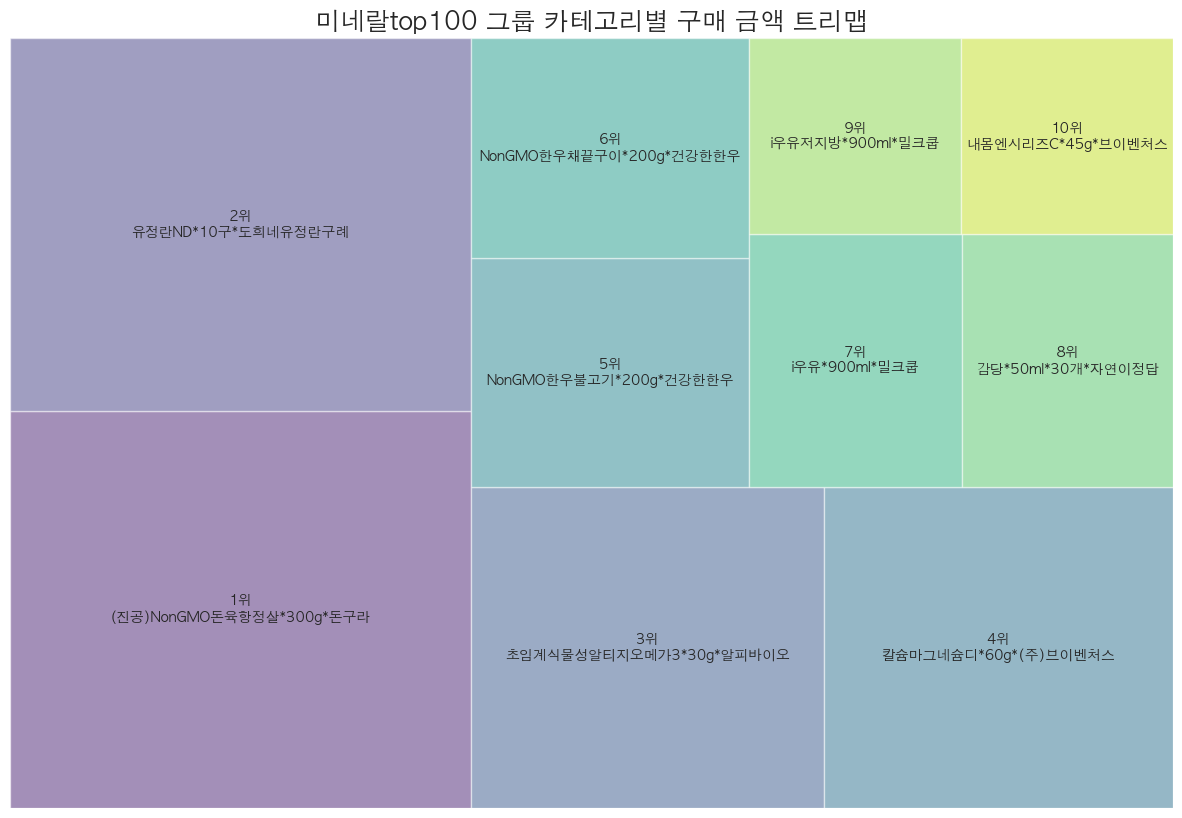

In [203]:
# 특정 keyword_rnk ('미네랄top100')에 대한 트리맵 그리기 예시
keyword = '미네랄top100'
filter_condition = (keyword_purchase_network['keyword_rnk'] == keyword) & (keyword_purchase_network['rnk'] <= 10)
filtered_df = keyword_purchase_network[filter_condition]

# 등수와 상품명을 함께 라벨로 표시
filtered_df['label'] = filtered_df.apply(lambda x: f"{x['rnk']}위\n{x['product_name']}", axis=1)

# 색상 팔레트 선택
cmap = sns.color_palette("viridis", len(filtered_df))
colors = [cmap[i] for i in range(len(filtered_df))]

# 트리맵 생성
plt.figure(figsize=(15, 10))
squarify.plot(
    sizes=filtered_df['purchase_amount'],
    label=filtered_df['label'],
    color=colors,  # 색상 적용
    alpha=0.5,
    text_kwargs={'fontsize': 10, 'weight': 'bold'}
)

# 그래프 설정
plt.title(f"{keyword} 그룹 카테고리별 구매 금액 트리맵", fontsize=18, fontweight='bold')
plt.axis('off')  # 축 제거
plt.show()


-  유기농 구매 Top100명의 주 구매 카테고리

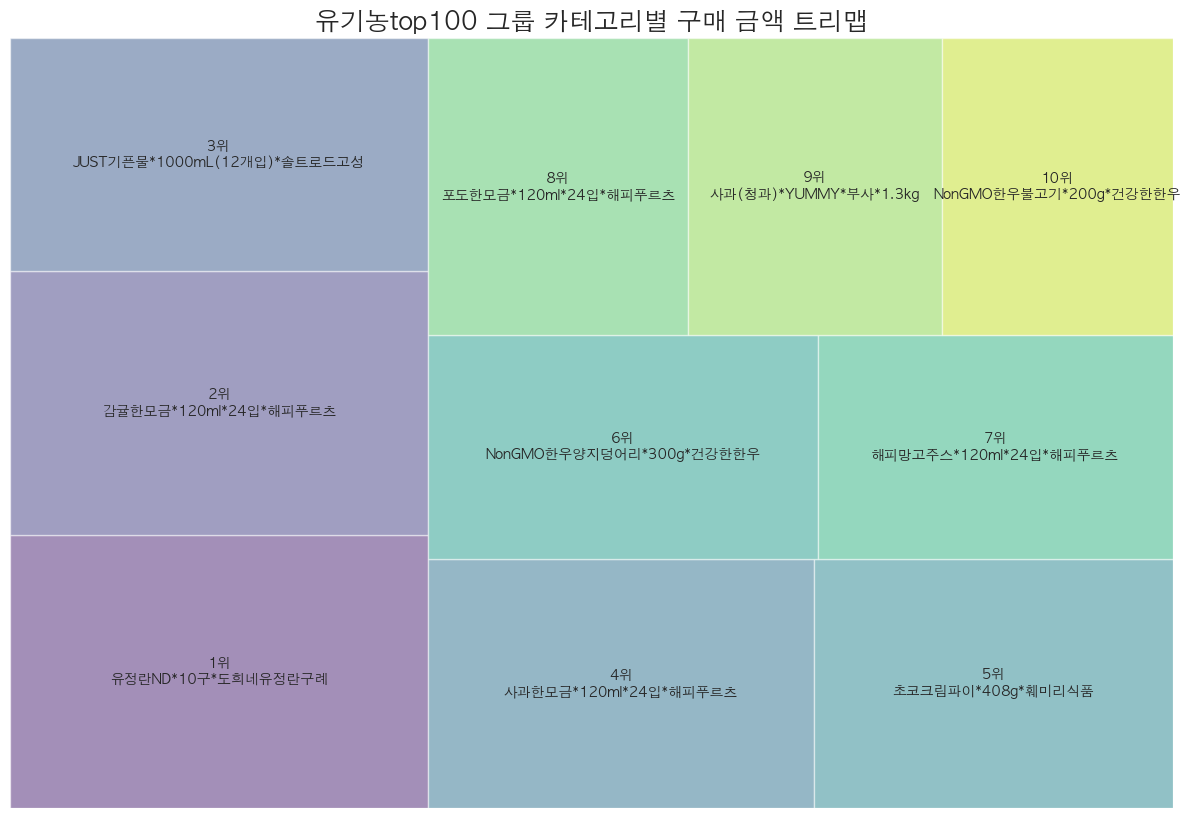

In [204]:
# 특정 keyword_rnk ('유기농top100')에 대한 트리맵 그리기 예시
keyword = '유기농top100'
filter_condition = (keyword_purchase_network['keyword_rnk'] == keyword) & (keyword_purchase_network['rnk'] <= 10)
filtered_df = keyword_purchase_network[filter_condition]

# 등수와 상품명을 함께 라벨로 표시
filtered_df['label'] = filtered_df.apply(lambda x: f"{x['rnk']}위\n{x['product_name']}", axis=1)

# 색상 팔레트 선택
cmap = sns.color_palette("viridis", len(filtered_df))
colors = [cmap[i] for i in range(len(filtered_df))]

# 트리맵 생성
plt.figure(figsize=(15, 10))
squarify.plot(
    sizes=filtered_df['purchase_amount'],
    label=filtered_df['label'],
    color=colors,  # 색상 적용
    alpha=0.5,
    text_kwargs={'fontsize': 10, 'weight': 'bold'}
)

# 그래프 설정
plt.title(f"{keyword} 그룹 카테고리별 구매 금액 트리맵", fontsize=18, fontweight='bold')
plt.axis('off')  # 축 제거
plt.show()


- 파이토키네틱 구매 Top100명의 주 구매 카테고리

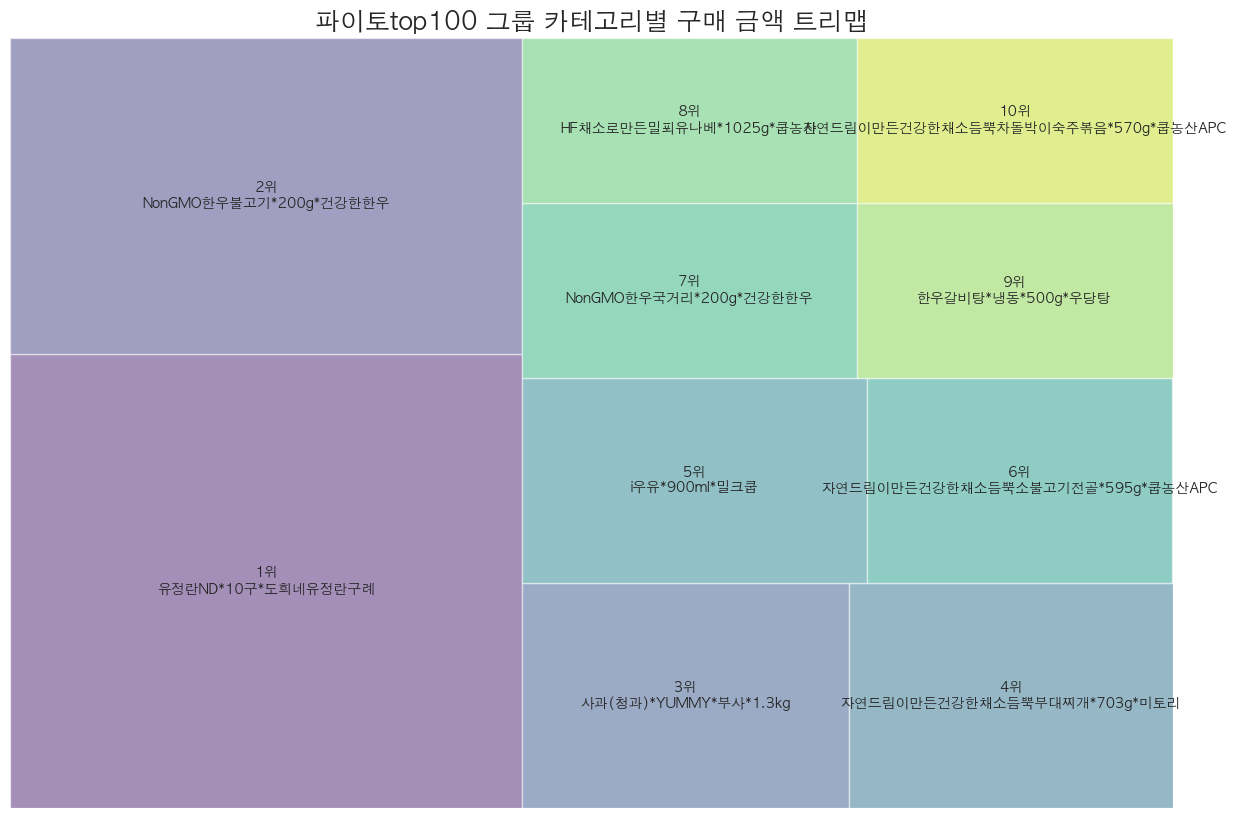

In [205]:
# 특정 keyword_rnk ('파이토top100')에 대한 트리맵 그리기 예시
keyword = '파이토top100'
filter_condition = (keyword_purchase_network['keyword_rnk'] == keyword) & (keyword_purchase_network['rnk'] <= 10)
filtered_df = keyword_purchase_network[filter_condition]

# 등수와 상품명을 함께 라벨로 표시
filtered_df['label'] = filtered_df.apply(lambda x: f"{x['rnk']}위\n{x['product_name']}", axis=1)

# 색상 팔레트 선택
cmap = sns.color_palette("viridis", len(filtered_df))
colors = [cmap[i] for i in range(len(filtered_df))]

# 트리맵 생성
plt.figure(figsize=(15, 10))
squarify.plot(
    sizes=filtered_df['purchase_amount'],
    label=filtered_df['label'],
    color=colors,  # 색상 적용
    alpha=0.5,
    text_kwargs={'fontsize': 10, 'weight': 'bold'}
)

# 그래프 설정
plt.title(f"{keyword} 그룹 카테고리별 구매 금액 트리맵", fontsize=18, fontweight='bold')
plt.axis('off')  # 축 제거
plt.show()


--- 
#### 2.3. **마케팅 효과 분석 (10월 25일 이후 분석 진행)**

- 2.3.1 외부 마케팅 효과 분석: 마케팅 동의 여부에 따른 구매 패턴 비교
> 주 단위 시계열 분석

In [35]:
# PostgreSQL 연결
postgre = PostgreSQL(config_file_path=config_path, request_url='local_postgre')
postgre.connect()

# 스키마 'online_mall'에서 테이블 목록 가져오는 쿼리
query = """
    select * 
    from app_online_mall.marketing_purchase_behavior
"""

marketing_purchase_behavior = postgre.read_data(query)
postgre.close() 

Initialize Class
Connected to PostgreSQL
PostgreSQL connection is closed


In [36]:
marketing_purchase_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150650 entries, 0 to 150649
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   member_code              150650 non-null  object
 1   member_status            150650 non-null  object
 2   member_type              150650 non-null  object
 3   agree_marketing_mall     150648 non-null  object
 4   agree_marketing_coop     150650 non-null  object
 5   agree_marketing_medical  150650 non-null  object
 6   purchased                150650 non-null  object
dtypes: object(7)
memory usage: 8.0+ MB


In [37]:
marketing_purchase_behavior.head()

,member_code,member_status,member_type,agree_marketing_mall,agree_marketing_coop,agree_marketing_medical,purchased
0,317454980,가능,골드,Z,N,N,Y
1,317463932,가능,골드,Z,N,N,Y
2,317472663,가능,골드,Z,N,N,Y
3,317484964,가능,골드,Z,N,N,Y
4,317488929,가능,골드,Z,N,N,Y


--- 

- 2.3.2 앱 오픈 전후 효과 분석 : 이벤트 전 (1,2,3월), 이벤트 후 (4,5,6월), 전환율 측정 기간 (7,8,9월)
> 그룹별 시각화


In [34]:
# PostgreSQL 연결
postgre = PostgreSQL(config_file_path=config_path, request_url='local_postgre')
postgre.connect()

# 스키마 'online_mall'에서 테이블 목록 가져오는 쿼리
query = """
    select * 
    from app_online_mall.marketing_effect
"""

marketing_effect = postgre.read_data(query)
postgre.close() 

Initialize Class
Connected to PostgreSQL
PostgreSQL connection is closed


In [32]:
marketing_effect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283870 entries, 0 to 283869
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   member_code       283870 non-null  object
 1   purchase_date     283870 non-null  object
 2   event_start_date  283870 non-null  object
 3   event_end_date    283870 non-null  object
 4   product_code      283870 non-null  object
 5   quantity          283870 non-null  int64 
 6   amount            283870 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 15.2+ MB


In [33]:
marketing_effect.head()

,member_code,purchase_date,event_start_date,event_end_date,product_code,quantity,amount
0,317495906,2024-01-24,2024-06-03,2024-06-30,11001GE400,2,14800
1,317495906,2024-01-24,2024-06-03,2024-06-30,12000IF900,3,5370
2,317495906,2024-01-24,2024-06-03,2024-06-30,20008IRA00,4,16320
3,317495906,2024-01-24,2024-06-03,2024-06-30,30007CH900,7,20580
4,317495906,2024-01-24,2024-06-03,2024-06-30,50050C8400,5,9150
